## Contents
1. Import Libraries and Set Directory
2. Data Cleaning
    * Functions
    * Total Demand
    * Temperature
    * Forecast Demand
    * Energy Prices and Demand
    * BOM
    * Solar Installations
    * Merge Datasets
3. Exploratory Data Analysis
    * Total Demand Timeseries
    * Temperature Timeseries
    * Rain Timeseries
    * Timeseries Comparison
    * Timeseries Comparison with Kernal Smoothing

In [98]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import zipfile
import tempfile # for temporary file storage to avoid storing large datasets on github
import matplotlib.pyplot as plt

In [99]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path)

In [100]:
# os.listdir()

## Data Cleaning

#### Functions

In [101]:
# read zips from repo, extract data into temp dir, create dataframes
def zip_to_df(file_name):
    # create temporary directory  
    with tempfile.TemporaryDirectory() as tmpdirname:
        # collect data from zip file 
        with zipfile.ZipFile(file_name+".zip") as zip_file:
            file_list = zip_file.namelist()
            for file in file_list:
                zip_file.extract(file, tmpdirname)
            file_path = tmpdirname+"\\"+file_name
            # create and return dataframe
            df = pd.read_csv(file_path)
            return df

In [102]:
def create_date_vars(df, col, day_req=True):
    df["DATE"] = df[col].dt.date
    df["YEAR"] = df[col].dt.year
    df["MONTH"] = df[col].dt.month
    if day_req == True: df["DAY"] = df[col].dt.day
#     df["TIME"] = df[col].dt.time
#     df["HOURS"] = df[col].dt.hour
#     df["MINUTES"] = df[col].dt.minute
    return df

#### Total Demand

In [103]:
file_name = "totaldemand_nsw.csv"
totalDemand = zip_to_df(file_name)
print("Rows:", len(totalDemand))

Rows: 1323398


In [104]:
#update datatypes
totalDemand['DATETIME'] = pd.to_datetime(totalDemand['DATETIME'])

In [105]:
# create new date variables
totalDemand = create_date_vars(totalDemand, "DATETIME")

In [106]:
# remove redundant columns
totalDemand = totalDemand.drop(columns=["REGIONID"], errors='ignore')

In [107]:
# aggregate on date
totalDemandAgg = totalDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
# totalDemandAgg = totalDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(totalDemandAgg))
totalDemandAgg.head()

Rows: 4596


,YEAR,MONTH,DAY,DATE,TOTALDEMAND
0,2010,1,1,2010-01-01,7793.463681
1,2010,1,2,2010-01-02,8012.314097
2,2010,1,3,2010-01-03,7393.354514
3,2010,1,4,2010-01-04,8254.502222
4,2010,1,5,2010-01-05,8832.004931


#### Temperature

In [108]:
file_name = "temperature_nsw.csv"
temperature = zip_to_df(file_name)
print("Rows:", len(temperature))

Rows: 247646


In [109]:
#update datatypes
temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])

In [110]:
# create new date variables
temperature = create_date_vars(temperature, "DATETIME")

In [111]:
# remove redundant columns
temperature = temperature.drop(columns=["LOCATION"], errors='ignore')

In [112]:
# aggregate on date
temperatureAgg = temperature.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
temperatureAgg = temperatureAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(temperatureAgg))
temperatureAgg.head()

Rows: 4593


,YEAR,MONTH,DAY,TEMPERATURE
0,2010,1,1,25.094000
1,2010,1,2,24.765385
2,2010,1,3,19.429825
3,2010,1,4,20.625926
4,2010,1,5,22.660417


#### Forecast Demand

In [113]:
file_name = "forecastdemand_nsw.csv"
forecastDemand = zip_to_df(file_name)
print("Rows:", len(forecastDemand))

Rows: 11619503


In [114]:
#update datatypes
forecastDemand['DATETIME'] = pd.to_datetime(forecastDemand['DATETIME'])
forecastDemand['LASTCHANGED'] = pd.to_datetime(forecastDemand['LASTCHANGED'])

In [115]:
# create new date variables
forecastDemand = create_date_vars(forecastDemand, "DATETIME")

In [116]:
# remove redundant columns
forecastDemand = forecastDemand.drop(columns=["REGIONID","LASTCHANGED","PREDISPATCHSEQNO","PERIODID"], errors='ignore')

In [117]:
# aggregate
forecastDemandAgg = forecastDemand.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
forecastDemandAgg = forecastDemandAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(forecastDemandAgg))
forecastDemandAgg.head()

Rows: 4560


,YEAR,MONTH,DAY,FORECASTDEMAND
0,2010,1,1,7747.906211
1,2010,1,2,7773.818583
2,2010,1,3,7462.384786
3,2010,1,4,8467.411400
4,2010,1,5,8784.750420


#### Energy Prices and Demand

In [118]:
#merge all files in folder
wd = path + r"\Price and Demand - 2010-22"
files = os.listdir(wd)
prices = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(wd + "\\" + file)
        prices = prices.append(file_df, ignore_index=True)
        file_count += 1
print("Merged", file_count, "files")

Merged 153 files


In [119]:
#remove additional headers
prices = prices[prices["REGION"]!="REGION"]
print("Rows:", len(prices))

Rows: 337488


In [120]:
#update datatypes
prices['SETTLEMENTDATE'] = pd.to_datetime(prices['SETTLEMENTDATE'])
prices['TOTALDEMAND'] = prices['TOTALDEMAND'].astype(float)
prices['RRP'] = prices['RRP'].astype(float)

In [121]:
# create new date variables
prices = create_date_vars(prices, "SETTLEMENTDATE")

In [122]:
# remove redundant columns
prices = prices.drop(columns=["REGION","PERIODTYPE"], errors='ignore')

In [123]:
# aggregate
pricesAgg = prices.groupby(["YEAR","MONTH","DAY","DATE"]).mean().reset_index()
pricesAgg = pricesAgg.drop(columns=["DATE"], errors='ignore')
print("Rows:", len(pricesAgg))
pricesAgg.head()

Rows: 4627


,YEAR,MONTH,DAY,TOTALDEMAND,RRP
0,2010,1,1,7796.317872,20.364894
1,2010,1,2,8017.459792,20.478125
2,2010,1,3,7399.899583,20.277083
3,2010,1,4,8241.720208,21.494583
4,2010,1,5,8827.813125,23.966042


#### BOM

In [124]:
# timeframe restriction
year_start = 2010

In [125]:
file_path = path + r"\Solar Exposure - Bankstown Airport\IDCJAC0016_066137_1800_Data.csv"
bomSolar = pd.read_csv(file_path)
bomSolar = bomSolar[bomSolar.Year >= year_start]
print("Rows:", len(bomSolar))

Rows: 4816


In [126]:
file_path = path + r"\Temperature - Bankstown Airport\IDCJAC0011_066137_1800_Data_Daily_Min_Temp.csv"
bomTempMin = pd.read_csv(file_path)
bomTempMin = bomTempMin[bomTempMin.Year >= year_start]
print("Rows:", len(bomTempMin))

Rows: 4830


In [127]:
file_path = path + r"\Temperature - Bankstown Airport\IDCJAC0010_066137_1800_Data_Daily_Max_Temp.csv"
bomTempMax = pd.read_csv(file_path)
bomTempMax = bomTempMax[bomTempMax.Year >= year_start]
print("Rows:", len(bomTempMax))

Rows: 4816


In [128]:
file_path = path + r"\Rainfall - Bankstown\IDCJAC0009_066137_1800_Data.csv"
bomRain = pd.read_csv(file_path)
bomRain = bomRain[bomRain.Year >= year_start]
print("Rows:", len(bomRain))

Rows: 4817


In [129]:
# remove redundant columns
bomSolar = bomSolar.drop(columns=["Product code","Bureau of Meteorology station number"], errors='ignore')
bomTempMin = bomTempMin.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomTempMax = bomTempMax.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')
bomRain = bomRain.drop(columns=["Product code","Bureau of Meteorology station number","Quality"], errors='ignore')

In [130]:
# merge bom datasets and rename headers
bom = bomTempMin.merge(bomTempMax, how="left", on=["Year","Month","Day"])
bom = bom.merge(bomRain, how="left", on=["Year","Month","Day"])
bom = bom.merge(bomSolar, how="outer", on=["Year","Month","Day"])
bom.columns = ['YEAR','MONTH','DAY',"MIN", "ACCMIN", 'MAX','ACCMAX','RAIN','RAINPERIOD','SOLAR']
print("Rows:", len(bom))
bom.head()

Rows: 4830


,YEAR,MONTH,DAY,MIN,ACCMIN,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR
0,2010,1,1,20.3,1.0,29.6,1.0,0.2,1.0,14.6
1,2010,1,2,22.2,1.0,29.5,1.0,0.0,1.0,18.4
2,2010,1,3,18.5,1.0,21.0,1.0,15.2,1.0,7.3
3,2010,1,4,17.8,1.0,24.0,1.0,0.2,1.0,14.4
4,2010,1,5,16.2,1.0,30.4,1.0,0.0,1.0,28.1


#### Solar Panels

In [131]:
#merge all files in folder
wd = path + r"\Solar Panel Installations - Bankstown"
files = os.listdir(wd)
sguSolar = pd.DataFrame([])
file_count = 0
for file in files:
    if file.endswith(".csv"):
        sgu = pd.read_csv(wd + "\\" + file)
        sgu = sgu[sgu["Small Unit Installation Postcode"]==2200]
        sgu = pd.melt(sgu, id_vars='Small Unit Installation Postcode')
        sgu = sgu[~sgu["variable"].str.contains("Previous Years")]
        sgu = sgu[~sgu["variable"].str.contains("Total")]
        sgu["Col"] = np.where(sgu["variable"].str.contains("Quantity"), "Quantity", "Output")
        sgu["variable"] = sgu["variable"].str.split('-').str[0]
        sgu["value"] = sgu["value"].astype(float)
        sgu = pd.pivot_table(sgu, values="value", columns="Col", index=["Small Unit Installation Postcode", "variable"]).reset_index()
        sguSolar = sguSolar.append(sgu, ignore_index=True, sort=False)
        file_count += 1
print("Merged", file_count, "files")
print("Rows:", len(sguSolar))
sguSolar.head()

Merged 12 files
Rows: 278


Col,Small Unit Installation Postcode,variable,Output,Quantity
0,2200,Apr 2009,0.99,1.0
1,2200,Apr 2010,12.64,6.0
2,2200,Aug 2009,1.02,1.0
3,2200,Aug 2010,25.20,15.0
4,2200,Dec 2009,13.32,4.0


In [132]:
# update datatypes
sguSolar["DATETIME"] = pd.to_datetime(sguSolar["variable"])

In [133]:
# remove redundant columns
sguSolar = sguSolar.drop(columns=["Small Unit Installation Postcode","variable"], errors='ignore')

In [134]:
# rename columns
sguSolar.columns = ["OUTPUT","QUANTITY","DATETIME"]

In [135]:
# create new date variables
sguSolar = create_date_vars(sguSolar, "DATETIME", day_req=False)

In [136]:
# calculate cumulative sum, ordered by date
sguSolar = sguSolar.sort_values(['DATE'], ascending=[True])
sguSolar["QUANTITYMONTHCUM"] = sguSolar.groupby(['DATE'])['QUANTITY'].cumsum(axis=0)
sguSolar["QUANTITYTOTALCUM"] = sguSolar['QUANTITY'].cumsum(axis=0)
sguSolar = sguSolar.drop(columns=["DATETIME","DATE"], errors='ignore')
print("Rows:", len(sguSolar))
sguSolar.head()

Rows: 278


,OUTPUT,QUANTITY,YEAR,MONTH,QUANTITYMONTHCUM,QUANTITYTOTALCUM
8,0.00,0.0,2009,1,0.0,0.0
6,0.00,0.0,2009,2,0.0,0.0
14,0.00,0.0,2009,3,0.0,0.0
0,0.99,1.0,2009,4,1.0,1.0
16,1.00,1.0,2009,5,1.0,2.0


#### Humidity

In [152]:
file_path = path + r"\humidity - 2010 01 to 2022 12.csv"
humidity = pd.read_csv(file_path)
print("Rows:", len(humidity))

Rows: 4861


In [153]:
humidity["DATETIME"] = pd.to_datetime(humidity["DATE"])
humidity = humidity.iloc[:,1:]
humidity = create_date_vars(humidity, "DATETIME", day_req=False)
humidity = humidity.drop(columns=["DATE","DATETIME"], errors='ignore')
humidity.head()

,HUMIDITYAVE,HUMIDITYMIN,HUMIDITYMAX,YEAR,MONTH
0,0.675870,0.46,0.89,2010,1
1,0.675870,0.46,0.89,2010,1
2,0.735918,0.46,1.00,2010,1
3,0.832766,0.69,1.00,2010,1
4,0.706042,0.51,0.94,2010,1


#### Merge All Datasets

In [155]:
df = totalDemandAgg.merge(bom, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(pricesAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(forecastDemandAgg, how="left", on=["YEAR","MONTH","DAY"])
df = df.merge(sguSolar, how="left", on=["YEAR","MONTH"])
df = df.merge(humidity, how="left", on=["YEAR","MONTH"])
print("Rows:", len(df))
df.head() 

Rows: 254394


,YEAR,MONTH,DAY,DATE,TOTALDEMAND_x,MIN,ACCMIN,MAX,ACCMAX,RAIN,...,TOTALDEMAND_y,RRP,FORECASTDEMAND,OUTPUT,QUANTITY,QUANTITYMONTHCUM,QUANTITYTOTALCUM,HUMIDITYAVE,HUMIDITYMIN,HUMIDITYMAX
0,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,1.0,0.2,...,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,0.675870,0.46,0.89
1,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,1.0,0.2,...,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,0.675870,0.46,0.89
2,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,1.0,0.2,...,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,0.735918,0.46,1.00
3,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,1.0,0.2,...,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,0.832766,0.69,1.00
4,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,1.0,0.2,...,7796.317872,20.364894,7747.906211,1.53,1.0,1.0,20.0,0.706042,0.51,0.94


In [156]:
# add month date column
df['MONTHDATE'] = df['MONTH'].map(str)+ '-' +df['YEAR'].map(str)
df['MONTHDATE'] = pd.to_datetime(df['MONTHDATE'], format='%m-%Y').dt.strftime('%m-%Y')

In [163]:
# create average temperature
df["TEMPAVE"] = (df["MIN"] + df["MAX"]) / 2

In [164]:
# remove duplicate TOTALDEMAND column and rename
df = df.drop(columns=["TOTALDEMAND_y"], errors="ignore")
df = df.rename(columns={'TOTALDEMAND_x': 'TOTALDEMAND'})

In [165]:
# check for nulls
df.isna().sum()

YEAR              0
MONTH             0
DAY               0
DATE              0
TOTALDEMAND       0
MIN               0
ACCMIN            0
MAX               0
RAIN              0
SOLAR             0
RRP               0
FORECASTDEMAND    0
OUTPUT            0
HUMIDITYAVE       0
HUMIDITYMIN       0
HUMIDITYMAX       0
MONTHDATE         0
TEMPAVE           0
dtype: int64

In [166]:
# solar panel installations missing data for 2021 - remove this year for now
# remove rows with empty forecast demand, solar, temperatures
# replace nulls in rain columns with 0
df = df.dropna(axis=0, subset=['OUTPUT','SOLAR','MAX','FORECASTDEMAND'])
df = df.fillna(0)
df.isna().sum()

YEAR              0
MONTH             0
DAY               0
DATE              0
TOTALDEMAND       0
MIN               0
ACCMIN            0
MAX               0
RAIN              0
SOLAR             0
RRP               0
FORECASTDEMAND    0
OUTPUT            0
HUMIDITYAVE       0
HUMIDITYMIN       0
HUMIDITYMAX       0
MONTHDATE         0
TEMPAVE           0
dtype: int64

In [167]:
# remove unnessecary columns
df = df.drop(columns=["ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM"],errors="ignore")
df.head()

,YEAR,MONTH,DAY,DATE,TOTALDEMAND,MIN,ACCMIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,HUMIDITYAVE,HUMIDITYMIN,HUMIDITYMAX,MONTHDATE,TEMPAVE
0,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,0.2,14.6,20.364894,7747.906211,1.53,0.675870,0.46,0.89,01-2010,24.95
1,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,0.2,14.6,20.364894,7747.906211,1.53,0.675870,0.46,0.89,01-2010,24.95
2,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,0.2,14.6,20.364894,7747.906211,1.53,0.735918,0.46,1.00,01-2010,24.95
3,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,0.2,14.6,20.364894,7747.906211,1.53,0.832766,0.69,1.00,01-2010,24.95
4,2010,1,1,2010-01-01,7793.463681,20.3,1.0,29.6,0.2,14.6,20.364894,7747.906211,1.53,0.706042,0.51,0.94,01-2010,24.95


In [162]:
# save cleaned and merged dataset as csv
target_dir = os.getcwd() + "\\Cleaned data\\"
df.to_csv(target_dir+"data.csv",index=False)

## Exploratory Data Analysis

In [221]:
df.describe()

,YEAR,MONTH,DAY,TOTALDEMAND,MAX,ACCMAX,RAIN,RAINPERIOD,SOLAR,RRP,FORECASTDEMAND,OUTPUT,QUANTITY,QUANTITYMONTHCUM,QUANTITYTOTALCUM
count,8248.000000,8248.000000,8248.000000,8248.000000,8208.000000,8208.0,8066.000000,8064.0,8246.000000,8248.000000,8183.000000,7883.000000,7883.000000,7883.000000,7883.000000
mean,2015.225145,6.459020,15.725267,8111.543731,24.125938,1.0,2.470146,1.0,15.839389,62.068918,8066.977269,67.453317,11.239376,16.232145,1643.883293
std,3.382902,3.442087,8.800412,804.685607,5.493147,0.0,8.747097,0.0,7.321437,64.504773,804.693001,73.940852,10.164189,16.603299,742.800165
min,2010.000000,1.000000,1.000000,5970.921181,9.600000,1.0,0.000000,1.0,1.000000,14.362222,5518.989111,0.000000,0.000000,0.000000,20.000000
25%,2012.000000,3.000000,8.000000,7555.606623,19.700000,1.0,0.000000,1.0,10.500000,32.871667,7497.938463,24.480000,6.000000,7.000000,1227.000000
50%,2015.000000,6.000000,16.000000,8056.711771,23.700000,1.0,0.000000,1.0,14.600000,50.562813,8026.797902,41.160000,9.000000,12.000000,1765.000000
75%,2018.000000,9.000000,23.000000,8655.697066,27.800000,1.0,0.400000,1.0,21.000000,73.981719,8627.338480,79.570000,13.000000,20.000000,2199.000000
max,2022.000000,12.000000,31.000000,11537.208785,47.000000,1.0,159.600000,1.0,34.200000,1539.430000,11234.220537,458.355000,73.000000,146.000000,2950.000000


#### Timeseries

In [222]:
df_lim = df[df["YEAR"]>2020]

In [223]:
# set variables
xDate = df_lim.DATE
xMonth = df_lim['MONTHDATE']
yTemp = df_lim.MAX
yDemand = df_lim.TOTALDEMAND
yRain = df_lim.RAIN
ySolar = df_lim.SOLAR 
yPanels = df_lim.QUANTITYTOTALCUM

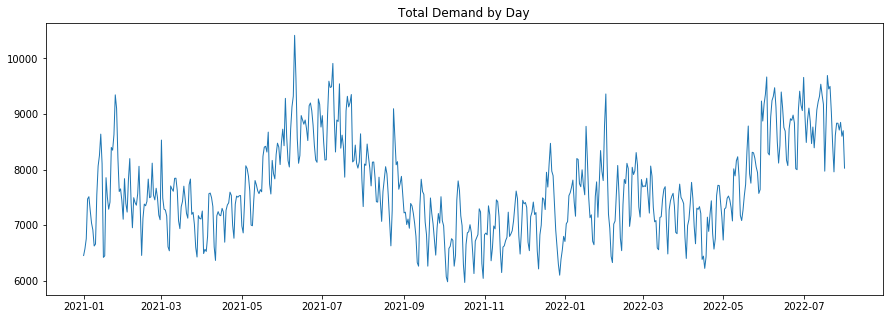

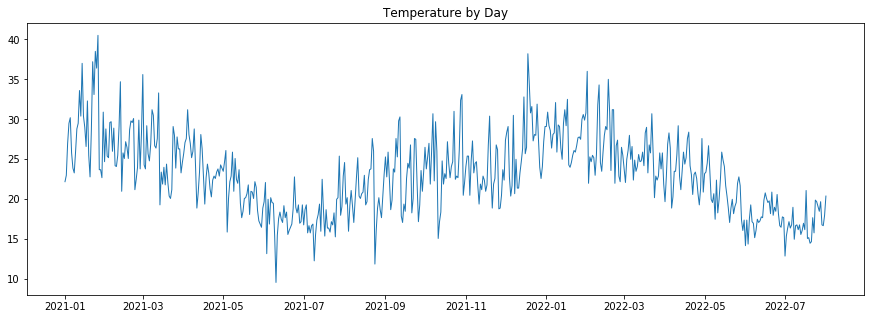

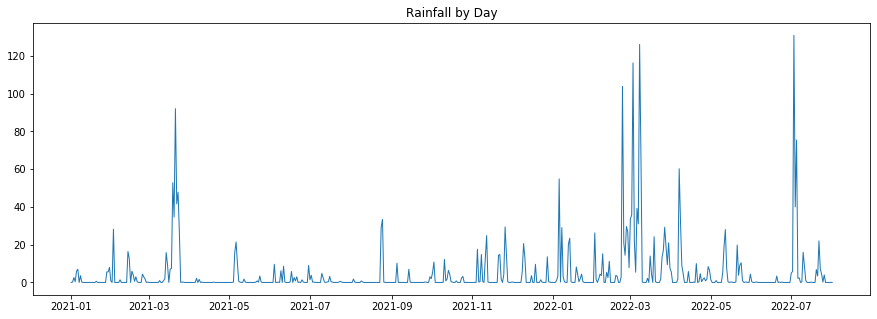

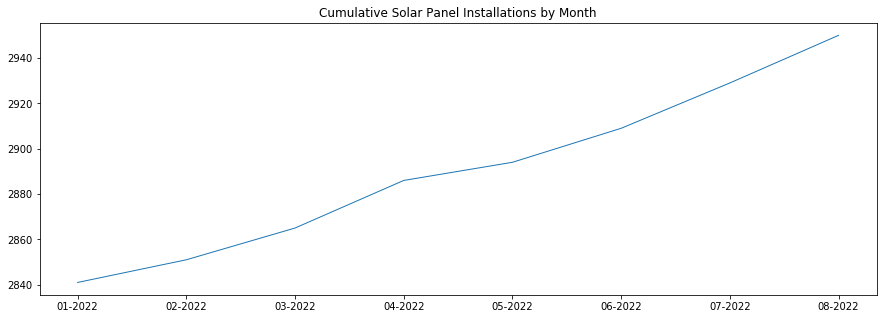

In [224]:
# Demand
plt.figure(figsize=(15,5))
plt.plot(xDate, yDemand, linewidth=1)
plt.title("Total Demand by Day")
plt.show() 

# Temperature
plt.figure(figsize=(15,5))
plt.plot(xDate, yTemp, linewidth=1)
plt.title("Temperature by Day")
plt.show() 

# Rain
plt.figure(figsize=(15,5))
plt.plot(xDate, yRain, linewidth=1)
plt.title("Rainfall by Day")
plt.show() 

# Cumulative Solar Panel Installations (monthly)
plt.figure(figsize=(15,5))
plt.plot(xMonth, yPanels, linewidth=1)
plt.title("Cumulative Solar Panel Installations by Month")
plt.show() 

#### Smoothing

In [225]:
# df_lim = df[df["YEAR"]>2020]
df_agg = df.groupby(['MONTHDATE']).mean().reset_index()

In [226]:
# update date types
df_agg['MONTHDATE'] = pd.to_datetime(df_agg.MONTHDATE)
df_agg = df_agg.sort_values("MONTHDATE")

In [227]:
# set variables
xDate = df_agg.MONTHDATE
xMonth = df_agg.MONTHDATE
yTemp = df_agg.MAX
yDemand = df_agg.TOTALDEMAND
yRain = df_agg.RAIN
ySolar = df_agg.SOLAR 
yPanels = df_agg.QUANTITYTOTALCUM

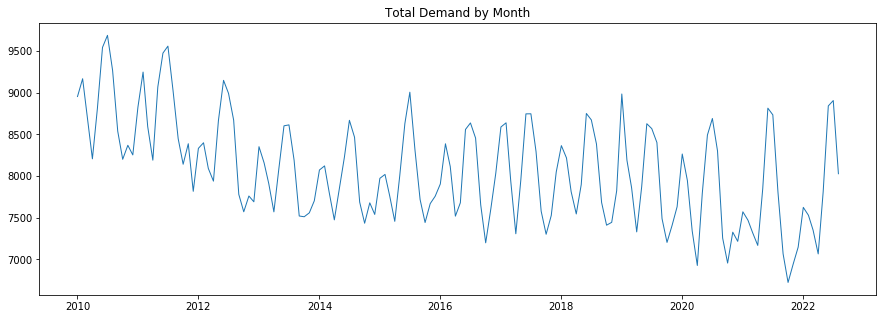

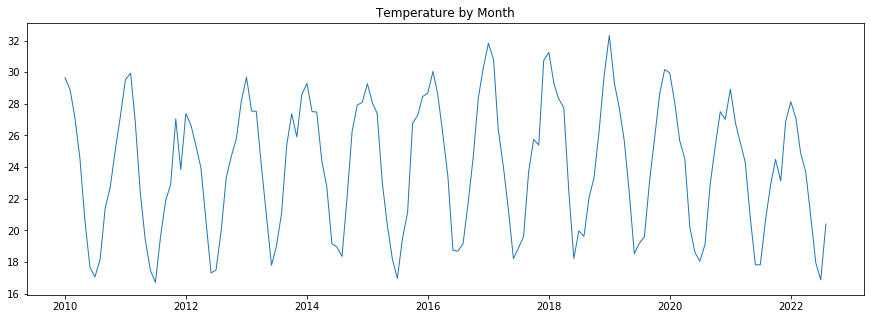

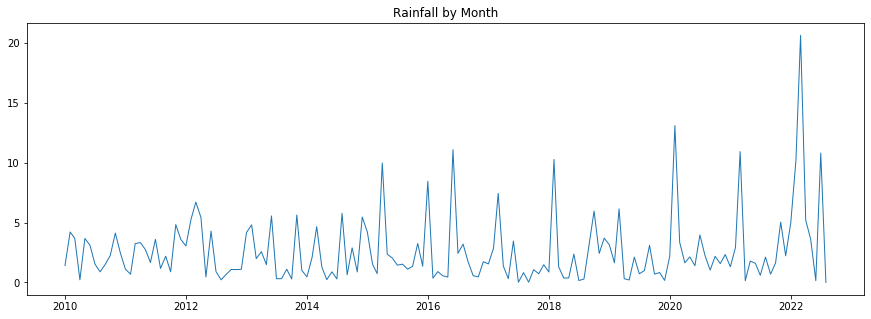

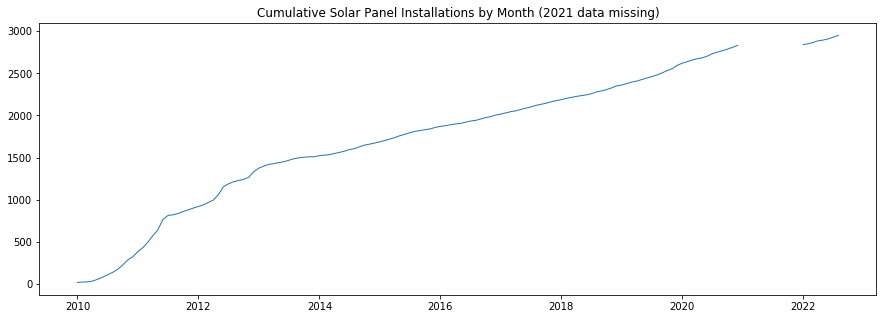

In [229]:
# Demand
plt.figure(figsize=(15,5))
plt.plot(xDate, yDemand, linewidth=1)
plt.title("Total Demand by Month")
plt.show() 

# Temperature
plt.figure(figsize=(15,5))
plt.plot(xDate, yTemp, linewidth=1)
plt.title("Temperature by Month")
plt.show() 

# Rain
plt.figure(figsize=(15,5))
plt.plot(xDate, yRain, linewidth=1)
plt.title("Rainfall by Month")
plt.show() 

# Cumulative Solar Panel Installations (monthly)
plt.figure(figsize=(15,5))
plt.plot(xMonth, yPanels, linewidth=1)
plt.title("Cumulative Solar Panel Installations by Month (2021 data missing)")
plt.show() 

### Testing / Working

In [ ]:
df_lim = df[df["YEAR"]>2020]

In [ ]:
# # Total Demand
# x = df_lim.DATETIME
# y1 = df_lim.TOTALDEMAND_x
# y2 = df_lim.TOTALDEMAND_y

# fig, ax = plt.subplots(figsize=(15,5))

# ax.plot(x, y1, linewidth=0.5, label='TOTAL DEMAND (Total Demand)', color="orange")
# ax.plot(x, y2, linewidth=0.5, label='TOTALDEMAND (prices)')

# ax.set_title("TOTALDEMAND")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)

# plt.show() 

In [ ]:
# set variables
xAgg = df_lim.MONTHDATE
yTempAgg = df_lim.MAX
yDemandAgg = df_lim.TOTALDEMAND_x
yRainAgg = df_lim.RAIN
ySolarAgg = df_lim.SOLAR

In [ ]:
# Temperature
plt.figure(figsize=(15,5))
plt.plot(x, yTemp, linewidth=1)
plt.show() 

In [ ]:
# Rain
plt.figure(figsize=(15,5))
plt.plot(x, yRain, linewidth=1)
plt.show() 

In [ ]:
# # compare all variables
# fig, ax1 = plt.subplots(figsize=(15,5))
# ax2 = ax1.twinx()
# ax3 = ax1.twinx()
# ax1.plot(x, yDemand, linewidth=0.1, label='TOTALDEMAND', color="purple")
# ax2.plot(x, yTemp, linewidth=1, label='TEMP', color="orange")
# ax3.bar(x, yRain, linewidth=1, label='RAIN')
# plt.show() 

In [ ]:
# compare all variables, but apply kernal smoothing on demand and temp
yTempSeries = pd.Series(yTemp)
yTempSmooth = yTempSeries.rolling(window=15, win_type='gaussian', center=True).mean(std=0.5)
yDemandSeries = pd.Series(yDemand)
yDemandSmooth = yDemandSeries.rolling(window=50, win_type='gaussian', center=True).mean(std=0.5)

In [ ]:
dfCopy = df.copy()
dfCopy["MAXSMOOTH"] = yTempSmooth
dfCopy["TOTALDEMANDSMOOTH"] = yDemandSmooth
dfCopy.head()

In [ ]:
# compare all variables
x = dfCopy.DATETIME
y = dfCopy.TOTALDEMANDSMOOTH
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(x, y, linewidth=0.1, label='TOTALDEMAND', color="purple")
plt.show() 